In [2]:
import cv2
import numpy as np

from PIL import Image
from collections import Counter

import matplotlib.pyplot as plt
from PIL import ImageDraw
import pytesseract

In [3]:
def load(image_path):
    cv_image = cv2.cvtColor(np.array(Image.open(image_path)), cv2.COLOR_RGB2BGR)
    return Image.open(image_path), cv_image

In [4]:
def most_popular_color(cv_image, top_colors=3):
    common_colors = Counter(map(tuple, cv_image.reshape(-1, 3))).most_common(top_colors)
    return [np.array(color[0], dtype=np.uint8) for color in common_colors]

In [5]:
def remove_background(cv_image, background_colors):
    mask = np.zeros(cv_image.shape[:2], dtype=np.uint8)
    for color in background_colors:
        temp_mask = cv2.inRange(cv_image, color, color)
        mask = cv2.bitwise_or(mask, temp_mask)
        
    return cv2.bitwise_and(cv_image, cv_image, mask=cv2.bitwise_not(mask))


In [6]:
def find_imgs(cv_image, min_size=50):
    gray_image = cv2.cvtColor(cv_image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rectangles = [cv2.boundingRect(contour) for contour in contours if cv2.boundingRect(contour)[2] > min_size and cv2.boundingRect(contour)[3] > min_size]
    
    return rectangles


In [7]:
def extract_regions(original_image, rectangles, target_size=(224, 224)):
    sizes = [(w, h) for _, _, w, h in rectangles]

    size_counts = Counter(sizes)
    most_common_size, _ = size_counts.most_common(1)[0]
    width, height = most_common_size

    # кароче тут +- 10% от самого популярного изображения
    min_width, max_width = width * 0.9, width * 1.1
    min_height, max_height = height * 0.9, height * 1.1
    
    regions = []
    for (x, y, w, h) in rectangles:
        if min_width <= w <= max_width and min_height <= h <= max_height:
            region = original_image.crop((x, y, x + w, y + h))
            if not len(pytesseract.image_to_string(region).strip()) > 10:
                regions.append(region.resize(target_size, Image.Resampling.LANCZOS))
                
    return regions

In [8]:
def process(image_path):
    original_image, cv_image = load(image_path)
    background_colors = most_popular_color(cv_image)
    foreground_image = remove_background(cv_image, background_colors)
    rectangles = find_imgs(foreground_image)

    #отрисовка
    display_image = original_image.copy()
    draw = ImageDraw.Draw(display_image)
    for (x, y, w, h) in rectangles:
        draw.rectangle([(x, y), (x + w, y + h)], outline="red", width=2)

    plt.figure(figsize=(10, 10))
    plt.imshow(display_image)
    plt.axis("off")
    plt.show()
    
    return extract_regions(original_image, rectangles)

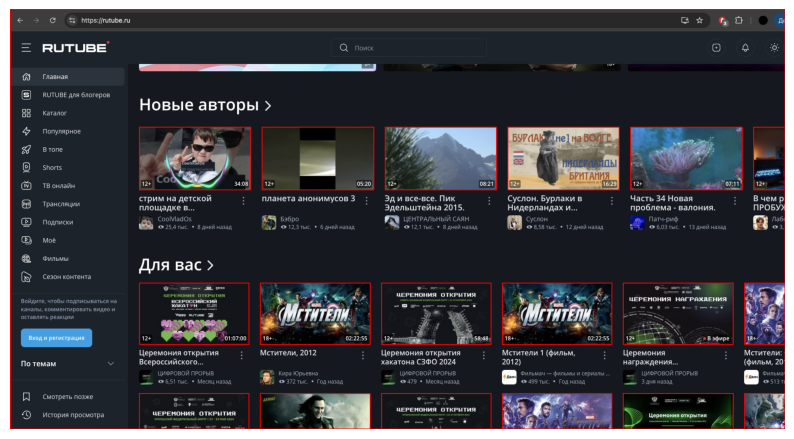

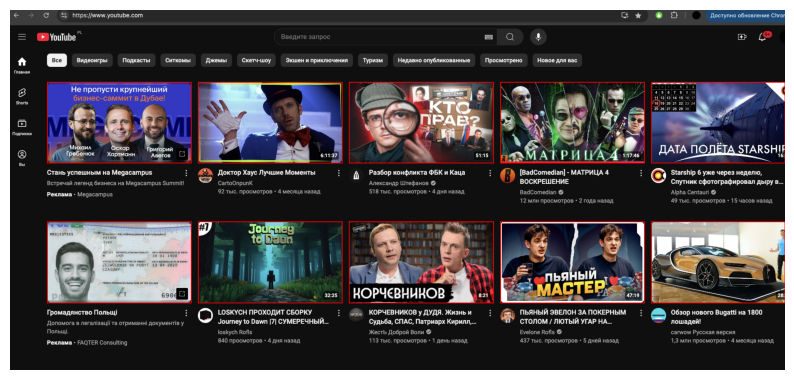

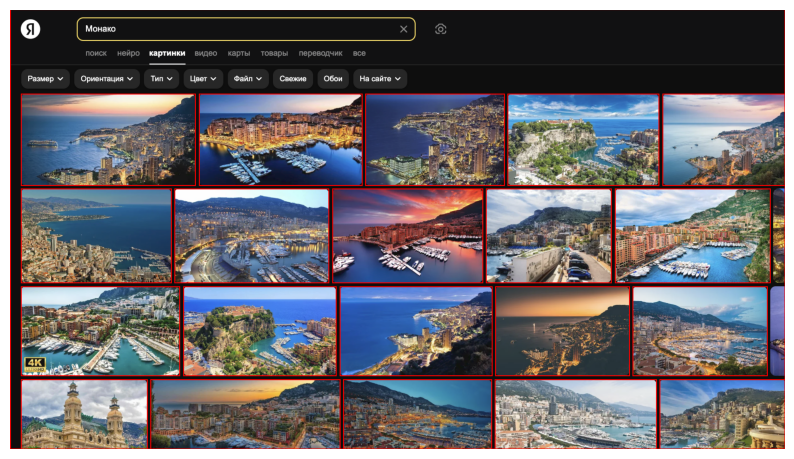

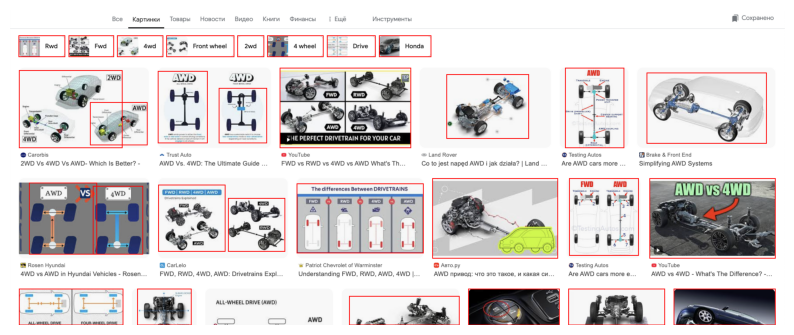

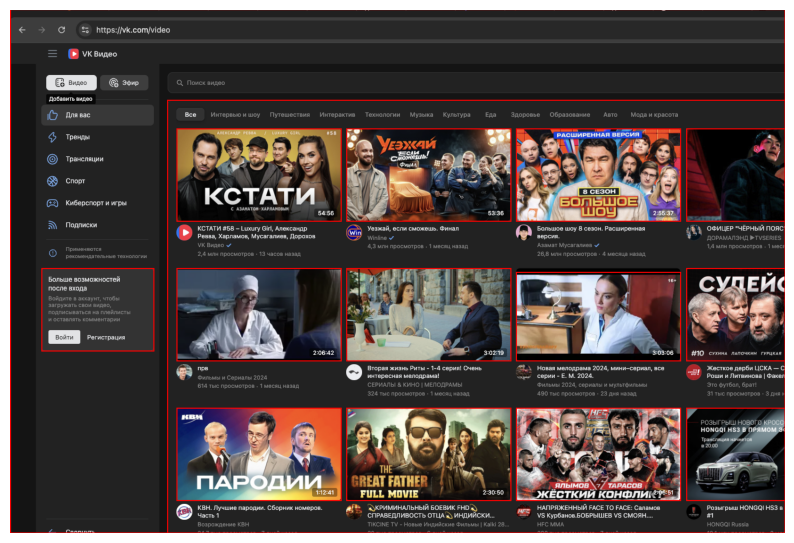

In [9]:
import os
def main(directory_path="screenshots"):
    for filename in os.listdir(directory_path):
        if filename.endswith((".png", ".jpg", ".jpeg")):
            image_path = os.path.join(directory_path, filename)
            regions = process(image_path)

main("screenshots")